In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gpplot as gpp
from scipy.stats import normaltest


gpp.set_aesthetics(context = 'paper')

Overall comparison between Jacquere (at 3 guides per gene) to existing CRISPRko Cas9 Genome Wide libraries.

In [2]:
path_to_annotations="../Data/GENCODE47 Mappings of CRISPRko Cas9 Genome Wide Libraries/"

library_labels=["GeCKOv2",
                "Avana",
                "Brunello",
                "Proj.Score",
                "TKOv3",
                "Gattinara",
                "VBC",
                "MinLib",
                "Jacquere"]


## GENCODE47 coverage 
Assess the coverage of GENCODE47 offered by various Genome Wide CRISPRko Cas9 libraries by identifying the % of GENCODE47 genes to which 0 guides map from each.

Guide sequences for each library are retrieved from files in the "Original Annotations of CRISPRko Cas9 Genome Wide Libraries" Data folder.

To retrieve guide mappings in GENCODE 47, guide sequences are inserted into a GPP Internal LIMS tool. 


GeCKO v2 (2014): 6 guides/gene

In [3]:
gecko_a=pd.read_csv(path_to_annotations+"gecko_a_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")
gecko_b=pd.read_csv(path_to_annotations+"gecko_b_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")
gecko=pd.concat([gecko_a,gecko_b])

Avana (2016): 
4 guides/gene screened for DepMap. Downloaded from [DepMap](https://depmap.org/portal/data_page/?tab=allData&releasename=DepMap+Public+24Q4&filename=AvanaGuideMap.csv)

In [4]:
avana=pd.read_csv(path_to_annotations+"avana_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

Brunello (2016)


In [5]:
brunello=pd.read_csv(path_to_annotations+"brunello_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

Human Sanger Genome Wide Library v1 (2016)

human genome-wide CRISPR library (v1) consisting of 90,709 gRNAs targeting a total of 18,010 genes. From [Tzelepis 2016](https://pmc.ncbi.nlm.nih.gov/articles/PMC5081405/#mmc2), used for [Project Score](https://score.depmap.sanger.ac.uk/documentation) 

note: I manually curated the projscore.csv file from the MinLibCas9 github MasterLib_v1 [file](https://github.com/EmanuelGoncalves/crispy/blob/master/notebooks/minlib/libraries/MasterLib_v1.csv.gz) to be 20 nt long

In [6]:
projscore=pd.read_csv(path_to_annotations+"hsangerv1_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

TKOv3 (2017)
[source paper](https://academic.oup.com/g3journal/article/7/8/2719/6031511?login=true)
70,948 gRNAs targeting 18,053 protein-coding genes (up to 4 sgRNA/gene)

In [7]:
tkov3=pd.read_csv(path_to_annotations+"tkov3_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

Gattinara (2018)

In [8]:
gattinara=pd.read_csv(path_to_annotations+"gattinara_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

VBC (2020) reports the 6 guides per gene with the top [VBC activity scores](https://www.nature.com/articles/s41592-020-0850-8) . Retrieved from vbc-score.org

In [9]:
vbc=pd.read_csv(path_to_annotations+"vbc_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

MinLibCas9 (2021)
[source: Goncalves et al 2021](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02268-4#Sec15)
covers 18,761 protein-coding genes with 37,522 sgRNAs (33,986 Project Score; 1732 Brunello; 1493 Avana and 311 TKOv3). Preferentially selected guides with demonstrated activity in Project Score data.

In [10]:
minlibcas9=pd.read_csv(path_to_annotations+"minlibcas9_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

Jacquere (2025)

In [11]:
jacquere= pd.read_csv(path_to_annotations+"jacquere_quota3_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")

I acquired all protein coding genes in Ensembl.v113 (which reflects GENCODE47) by doing a CRISPick run of all protein coding genes. 
I copied this list as input to HGNC when determining target annotations for Jacquere, so acquiring the list from that file. 

In [12]:
gencode47_allproteincoding= pd.read_table("../../4. Jacquere Design/Data/ensembl_113_protein_coding_aggcfd_targetlocal-sgrna-designs.txt")
gencode47_allproteincoding=gencode47_allproteincoding.drop_duplicates(subset="Target Gene ID",keep="first")[["Target Gene Symbol"]].dropna()


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_96097/2415063469.py:1: DtypeWarning: Columns (27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode47_allproteincoding= pd.read_table("../../4. Jacquere Design/Data/ensembl_113_protein_coding_aggcfd_targetlocal-sgrna-designs.txt")


In [13]:
#file to get count of guides targeting each ensembl gene from indicated library (guides mapped with LIMS tool)
def get_unique_genes_targeted(LIMSfile,library):
    LIMSfile["Target Gene Symbol"]=LIMSfile["On-target Gene Symbols"].str.split(",")
    LIMSfile_long=LIMSfile.explode("Target Gene Symbol")
    LIMSfile_genecounts=pd.DataFrame(LIMSfile_long["Target Gene Symbol"].value_counts()).reset_index()
    LIMSfile_genecounts=LIMSfile_genecounts.rename(columns={ "count":library})
    return LIMSfile_genecounts

gecko_counts=get_unique_genes_targeted(gecko,"gecko")
avana_counts=get_unique_genes_targeted(avana,"avana")
brunello_counts=get_unique_genes_targeted(brunello,"brunello")
projscore_counts=get_unique_genes_targeted(projscore,"projscore")
tkov3_counts=get_unique_genes_targeted(tkov3,"tkov3")
gattinara_counts=get_unique_genes_targeted(gattinara,"gattinara")
vbc_counts=get_unique_genes_targeted(vbc,"vbc")
minlibcas9_counts=get_unique_genes_targeted(minlibcas9,"minlibcas9")
jacquere_counts=get_unique_genes_targeted(jacquere,"jacquere")

In [14]:
all_counts=pd.merge(gencode47_allproteincoding,gecko_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,avana_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,brunello_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,projscore_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,tkov3_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,gattinara_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,vbc_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,minlibcas9_counts,on="Target Gene Symbol",how="left")
all_counts=pd.merge(all_counts,jacquere_counts,on="Target Gene Symbol",how="left")

all_counts=all_counts.replace(np.nan,0)
all_counts

,Target Gene Symbol,gecko,avana,brunello,projscore,tkov3,gattinara,vbc,minlibcas9,jacquere
0,TSPAN6,6.0,4.0,4.0,5.0,4.0,2.0,6.0,2.0,3.0
1,TNMD,6.0,4.0,4.0,5.0,4.0,2.0,6.0,2.0,3.0
2,DPM1,7.0,4.0,4.0,5.0,4.0,2.0,6.0,2.0,3.0
3,SCYL3,6.0,4.0,4.0,10.0,4.0,2.0,6.0,2.0,3.0
4,FIRRM,6.0,4.0,4.0,5.0,4.0,2.0,6.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
19468,IL9R,12.0,8.0,8.0,8.0,0.0,4.0,12.0,4.0,8.0
19469,MSL3B,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0
19470,DUSP13B,7.0,2.0,8.0,16.0,7.0,3.0,8.0,4.0,12.0
19471,DUSP13A,3.0,4.0,0.0,5.0,1.0,1.0,2.0,0.0,6.0


In [15]:
#identify % of GENCODE47 genes to which no guides in the library map
total=len(all_counts)
perc_gencode47_genes_untargeted_gecko= 100*len(all_counts[all_counts["gecko"]==0])/total
perc_gencode47_genes_untargeted_avana= 100*len(all_counts[all_counts["avana"]==0])/total
perc_gencode47_genes_untargeted_brunello= 100*len(all_counts[all_counts["brunello"]==0])/total
perc_gencode47_genes_untargeted_sanger= 100*len(all_counts[all_counts["projscore"]==0])/total
perc_gencode47_genes_untargeted_tkov3= 100*len(all_counts[all_counts["tkov3"]==0])/total
perc_gencode47_genes_untargeted_gattinara= 100*len(all_counts[all_counts["gattinara"]==0])/total
perc_gencode47_genes_untargeted_vbc= 100*len(all_counts[all_counts["vbc"]==0])/total
perc_gencode47_genes_untargeted_minlibcas9= 100*len(all_counts[all_counts["minlibcas9"]==0])/total
perc_gencode47_genes_untargeted_jacquere= 100*len(all_counts[all_counts["jacquere"]==0])/total

perc_gencode47_genes_untargeted=[round(perc_gencode47_genes_untargeted_gecko,2),round(perc_gencode47_genes_untargeted_avana,2),
                                 round(perc_gencode47_genes_untargeted_brunello,2),round(perc_gencode47_genes_untargeted_sanger,2),
                                 round(perc_gencode47_genes_untargeted_tkov3,2),round(perc_gencode47_genes_untargeted_gattinara,2),
                                 round(perc_gencode47_genes_untargeted_vbc,2),round(perc_gencode47_genes_untargeted_minlibcas9,2),
                                 round(perc_gencode47_genes_untargeted_jacquere,2)]
perc_gencode47_genes_untargeted


[2.72, 3.48, 2.23, 6.98, 7.57, 1.33, 1.73, 3.13, 0.61]

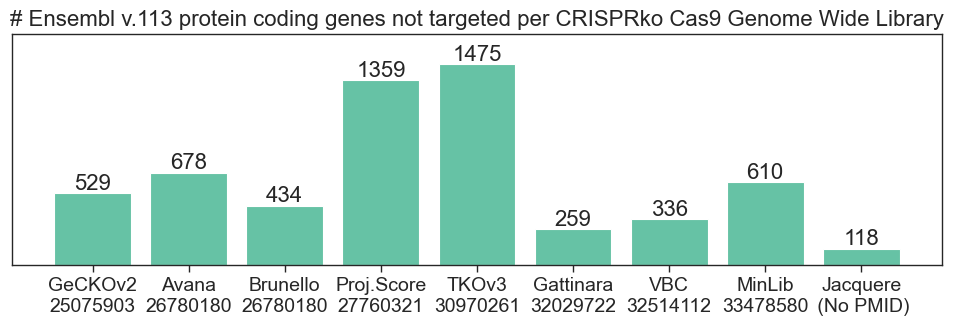

In [16]:
#getting number of untargeted genes per library 
(fig,ax)=plt.subplots(figsize=(12,3))

num_untargeted_genes= [len(all_counts[all_counts["gecko"]==0]),len(all_counts[all_counts["avana"]==0]),
                       len(all_counts[all_counts["brunello"]==0]),
                       len(all_counts[all_counts["projscore"]==0]),
                       len(all_counts[all_counts["tkov3"]==0]),
                       len(all_counts[all_counts["gattinara"]==0]),
                       len(all_counts[all_counts["vbc"]==0]),
                       len(all_counts[all_counts["minlibcas9"]==0]),
                       len(all_counts[all_counts["jacquere"]==0])]

#library name, quota, PMID
barplot_labels=["GeCKOv2\n25075903",
                "Avana\n26780180",
                "Brunello\n26780180",
                "Proj.Score\n27760321",
                "TKOv3\n30970261",
                "Gattinara\n32029722",
                "VBC\n32514112",
                "MinLib\n33478580",
                "Jacquere\n (No PMID)"]
ax.bar(barplot_labels,num_untargeted_genes)
ax.set_xticks(ticks=[0,1,2,3,4,5,6,7,8],labels=barplot_labels,fontsize=14)
ax.set_yticks([])
plt.ylim(0,1700) #keeps text on top from getting cut off 
plt.title("# Ensembl v.113 protein coding genes not targeted per CRISPRko Cas9 Genome Wide Library",fontsize=16)
ax.bar_label(ax.containers[0], fmt = '%d',size=16)
#gpp.savefig("../Figures/barplot_ensembl113_coverage_by_genomewidelibrary.png",bbox_inches="tight",dpi=600)


## Evaluating libraries with criteria from CRISPick
To contextualize the composition of Jacquere, I ran all evaluated CRISPRko Cas9 Genome Wide Libraries through CRISPick to determine the relative distributions of ...
- Guides that exceed the gnomAD variant frequency
- Aggregate CFD scores
- RS3 scores


In [66]:
#Get data for external libraries

folderpath= "../Data/CRISPick evaluated CRISPRko Cas9 Genome Wide Libraries/"

'''

For these CRISPick runs, I used Ensembl 113 as the reference genome and indicated targeting of all protein coding genes. 
I then supplied the set of guide sequences from the the "Original Annotations of CRISPRko Cas9 Genome Wide Libraries" Data folder. 
I indicated a quota of 1 and for CRISPick to show unpicked sequences.

'''

gecko=pd.read_table(folderpath+"gecko_bothsets_2_10_2025-sgrna-designs.txt",low_memory=False)
avana=pd.read_table(folderpath+"avana_2_10_2025-sgrna-designs.txt",low_memory=False)
brunello=pd.read_table(folderpath+"brunello_2_10_2025-sgrna-designs.txt",low_memory=False)
hsangerv1=pd.read_table(folderpath+"hsangerv1_2_10_2025-sgrna-designs.txt",low_memory=False)
tkov3=pd.read_table(folderpath+"tkov3_2_10_2025-sgrna-designs.txt",low_memory=False)
gattinara=pd.read_table(folderpath+"gattinara_2_10_2025-sgrna-designs.txt",low_memory=False)
vbc=pd.read_table(folderpath+"vbc-sgrna-designs.txt",low_memory=False)
minlibcas9=pd.read_table(folderpath+"minlibcas9_2_10_2025-sgrna-designs.txt",low_memory=False)
jacquere=pd.read_csv("../../4. Jacquere Design/Data/jacquere_assembled_crispick.csv")


#subset CRISPick runs to the guides that are actually in the libraries 
gecko=gecko[(gecko["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)
avana=avana[(avana["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)
brunello=brunello[(brunello["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)
hsangerv1=hsangerv1[(hsangerv1["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)
tkov3=tkov3[(tkov3["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)
gattinara=gattinara[(gattinara["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)
vbc=vbc[(vbc["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)
minlibcas9=minlibcas9[(minlibcas9["Picking Notes"].str.count("Preselect")>0)].reset_index(drop=True)


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_36148/2646541394.py:21: DtypeWarning: Columns (6,7,27) have mixed types. Specify dtype option on import or set low_memory=False.
  jacquere=pd.read_csv("../../4. Jacquere Design/Data/jacquere_assembled_crispick.csv")


#### RS3 (on-Target propensity) distributions across libraries

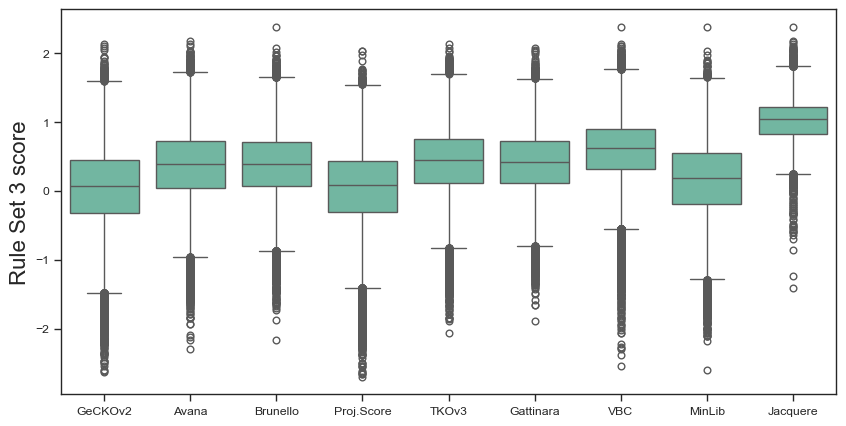

In [67]:
all_aggcfd_rs3=pd.concat([gecko[["Aggregate CFD Score","On-Target Efficacy Score"]],
           avana[["Aggregate CFD Score","On-Target Efficacy Score"]],
           brunello[["Aggregate CFD Score","On-Target Efficacy Score"]],
           hsangerv1[["Aggregate CFD Score","On-Target Efficacy Score"]],
           tkov3[["Aggregate CFD Score","On-Target Efficacy Score"]],
           gattinara[["Aggregate CFD Score","On-Target Efficacy Score"]],
            vbc[["Aggregate CFD Score","On-Target Efficacy Score"]],
           minlibcas9[["Aggregate CFD Score","On-Target Efficacy Score"]],
            jacquere[["Aggregate CFD Score","On-Target Efficacy Score"]]],
          keys=library_labels).reset_index().rename(columns={"level_0":"Library"}).drop(["level_1"],axis=1)

plt.figure(figsize=(10,5))
sns.boxplot(data=all_aggcfd_rs3,x="Library",y="On-Target Efficacy Score")
plt.ylabel("Rule Set 3 score",fontsize=16)
plt.xlabel("")
plt.savefig("../Figures/RS3_CRISPRko_Cas9_libraries.pdf",bbox_inches="tight",dpi=600)

#### Aggregate CFD (off-target propensity) distribution across libraries

In [68]:
# The next line of code excludes all guides that exceed 20,000 off-target sites. Here are the counts of such sites across libraries
all_aggcfd_rs3[all_aggcfd_rs3["Aggregate CFD Score"]=="MAX"].groupby(["Library"]).agg(num_MAX=("Aggregate CFD Score","count"))

,num_MAX
Library,
Avana,13
Brunello,7
GeCKOv2,66
VBC,10


In [69]:
all_aggcfd_rs3_dropmax=all_aggcfd_rs3[all_aggcfd_rs3["Aggregate CFD Score"]!="MAX"]
all_aggcfd_rs3_dropmax["Aggregate CFD Score"]=all_aggcfd_rs3_dropmax["Aggregate CFD Score"].astype(float)

total_library_guidecounts=all_aggcfd_rs3_dropmax.groupby(["Library"]).agg(total_library_guidecount=("Aggregate CFD Score","count"))

all_aggcfd_overthreshold=all_aggcfd_rs3_dropmax[all_aggcfd_rs3_dropmax["Aggregate CFD Score"]>4.8].reset_index(drop=True)
counts_aggcfd_overthreshold=all_aggcfd_overthreshold.groupby(["Library"]).agg(num_over_aggcfd_threshold=("Aggregate CFD Score","count"))
counts_aggcfd_overthreshold=counts_aggcfd_overthreshold.merge(total_library_guidecounts,left_index=True, right_index=True)
counts_aggcfd_overthreshold["frac_aggcfd_over_threshold"]= (counts_aggcfd_overthreshold["num_over_aggcfd_threshold"]/counts_aggcfd_overthreshold["total_library_guidecount"]).round(3)

aggcfdstats=all_aggcfd_rs3_dropmax.groupby(["Library"],sort=False).agg(mean_aggcfd=("Aggregate CFD Score","mean"))
aggcfdstats=aggcfdstats.merge(counts_aggcfd_overthreshold,left_index=True, right_index=True,how="left")
aggcfdstats=aggcfdstats.fillna(0)
aggcfdstats["Mean"]=aggcfdstats["mean_aggcfd"].round(3)
aggcfdstats["% >4.8"]=(aggcfdstats["frac_aggcfd_over_threshold"]*100).round(3)
aggcfdstats=aggcfdstats[["Mean","% >4.8"]]


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_36148/805151585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_aggcfd_rs3_dropmax["Aggregate CFD Score"]=all_aggcfd_rs3_dropmax["Aggregate CFD Score"].astype(float)


#### Representation of off-target sites with CFD Score = 1.0 across libraries

In [70]:
all_CFD1guides=pd.concat([gecko[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
           avana[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
           brunello[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
           hsangerv1[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
           tkov3[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
           gattinara[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
            vbc[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
           minlibcas9[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]],
            jacquere[["Off-Target CFD100 Hits","Off-Target Tier I CFD100 Hits"]]],
          keys=library_labels).reset_index().rename(columns={"level_0":"Library"}).drop(["level_1"],axis=1)

#drop guides with > 20,000 potential OTS (counts per library reported above)
all_CFD1guides_dropmax=all_CFD1guides[all_CFD1guides["Off-Target CFD100 Hits"]!="MAX"]
all_CFD1guides_dropmax["Off-Target CFD100 Hits"]=all_CFD1guides_dropmax["Off-Target CFD100 Hits"].astype(float)
all_CFD1guides_dropmax["Off-Target Tier I CFD100 Hits"]=all_CFD1guides_dropmax["Off-Target Tier I CFD100 Hits"].astype(float)

all_CFD100=all_CFD1guides_dropmax[all_CFD1guides_dropmax["Off-Target CFD100 Hits"]>0].reset_index(drop=True)
counts_CFD100=all_CFD100.groupby(["Library"],sort=False).agg(num_guides_with_CFD100_OTS=("Off-Target CFD100 Hits","count"))

all_CFD100_tierI=all_CFD1guides_dropmax[all_CFD1guides_dropmax["Off-Target Tier I CFD100 Hits"]>0].reset_index(drop=True)
counts_all_CFD100_tierI=all_CFD100_tierI.groupby(["Library"],sort=False).agg(num_guides_with_CFD100_tierI_OTS=("Off-Target Tier I CFD100 Hits","count"))

counts_all_CFD100=counts_CFD100.merge(counts_all_CFD100_tierI,left_index=True, right_index=True)
counts_all_CFD100=counts_all_CFD100.merge(total_library_guidecounts,left_index=True, right_index=True)
counts_all_CFD100["frac_CFD100"]= (counts_all_CFD100["num_guides_with_CFD100_OTS"]/counts_all_CFD100["total_library_guidecount"]).round(3)
counts_all_CFD100["frac_CFD100_tierI"]= (counts_all_CFD100["num_guides_with_CFD100_tierI_OTS"]/counts_all_CFD100["total_library_guidecount"]).round(3)

counts_all_CFD100["% "]=(counts_all_CFD100["frac_CFD100"]*100).round(2)
counts_all_CFD100["% Tier I"]=(counts_all_CFD100["frac_CFD100_tierI"]*100).round(2)
counts_all_CFD100=counts_all_CFD100[["% ","% Tier I"]]


/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_36148/1167492732.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_CFD1guides_dropmax["Off-Target CFD100 Hits"]=all_CFD1guides_dropmax["Off-Target CFD100 Hits"].astype(float)
/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_36148/1167492732.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_CFD1guides_dropmax["Off-Target Tier I CFD100 Hits"]=all_CFD1guides_dropmax["Off-Target Tier I CFD100 Hits"].astype(float)


Joining all metrics as one table

In [71]:
library_PMIDs=["25075903",
                "26780180",
                "26780180",
                "27760321",
                "30970261",
                "32029722",
                "32514112",
                "33478580",
                "NA"]

library_years=["2014","2016","2016","2016","2017","2018","2020","2021","2025"]

library_addgeneIDs=['1000000048',"NA","73178","67989","90294","136986","NA","164896","tbd"]

library_quotas= ["6","4","4","5","4","2","6","2","3"]

summary_table= pd.DataFrame({"Library":library_labels,"Release Year":library_years,"# Guides per gene":library_quotas,"PubMed ID":library_PMIDs,"Addgene ID":library_addgeneIDs,"% of GENCODE47 genes untargeted":perc_gencode47_genes_untargeted})
summary_table.columns=pd.MultiIndex.from_arrays([["","","","","",""],["Library","Release Year","#Guides per gene","PMID","Addgene ID","% of GENCODE47 genes untargeted"]])

aggcfdstats_reset=aggcfdstats.reset_index()
aggcfdstats_reset.columns=pd.MultiIndex.from_arrays([["","Aggregate CFD","Aggregate CFD"],["Library","Mean","% >4.8"]])
summary_table=summary_table.merge(aggcfdstats_reset)

counts_all_CFD100_reset=counts_all_CFD100.reset_index()
counts_all_CFD100_reset.columns=pd.MultiIndex.from_arrays([["","CFD 1.0 OTS","CFD 1.0 OTS"],["Library","%","% Tier I"]])
summary_table=summary_table.merge(counts_all_CFD100_reset)

summary_table

\
      Library Release Year #Guides per gene      PMID  Addgene ID   
0     GeCKOv2         2014                6  25075903  1000000048   
1       Avana         2016                4  26780180          NA   
2    Brunello         2016                4  26780180       73178   
3  Proj.Score         2016                5  27760321       67989   
4       TKOv3         2017                4  30970261       90294   
5   Gattinara         2018                2  32029722      136986   
6         VBC         2020                6  32514112          NA   
7      MinLib         2021                2  33478580      164896   
8    Jacquere         2025                3        NA         tbd   

                                  Aggregate CFD        CFD 1.0 OTS           
  % of GENCODE47 genes untargeted          Mean % >4.8           % % Tier I  
0                            2.72         3.114    2.9        14.3      3.4  
1                            3.48         2.131    4.6        15.4      3.3  
2                            2.23         0.793    2.2         6.2      3.3  
3                            6.98         0.635    1.4         9.8      2.4  
4                            7.57         0.760    1.1        11.1      1.3  
5                            1.33         1.014    3.1        13.1      3.8  
6                            1.73         1.126    2.8        12.6      1.8  
7                            3.13         0.576    1.2         6.3      2.1  
8                            0.61         0.781    0.0         3.2      2.2

In [72]:
summary_table.to_csv("../Figures/GenomeWide_CRISPRkoCas9_librarycomparison.csv",index=False)